<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/ML_MVcpo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importing Required Libraries

In [118]:
import plotly.express as px 
import matplotlib.dates as mdates
from statsmodels.tsa.api import SimpleExpSmoothing
from datetime import datetime
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')

from sklearn import metrics
from sklearn.metrics import explained_variance_score
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [80]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Loading Data

In [97]:
df = pd.read_csv("https://raw.githubusercontent.com/mofuoku417/multivariate-time-series-prediction-of-crude-palm-oil-price-data-science-approach/main/cleaned_data/preprocessed.csv")
 #removed unwanted column
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df.head()

,Date,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
0,2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
1,2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2,2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
3,2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
4,2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


In [98]:
df.index = pd.to_datetime(df['Date'], format='%Y.%m.%d')

In [99]:
df.head()

,Date,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,,
2002-02-01,2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


In [100]:
del df['Date']

In [101]:
df.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


In [102]:
#Copy the Dataframe
df1 = df.copy()

###Target Plot

Text(0.5, 0, 'Date')

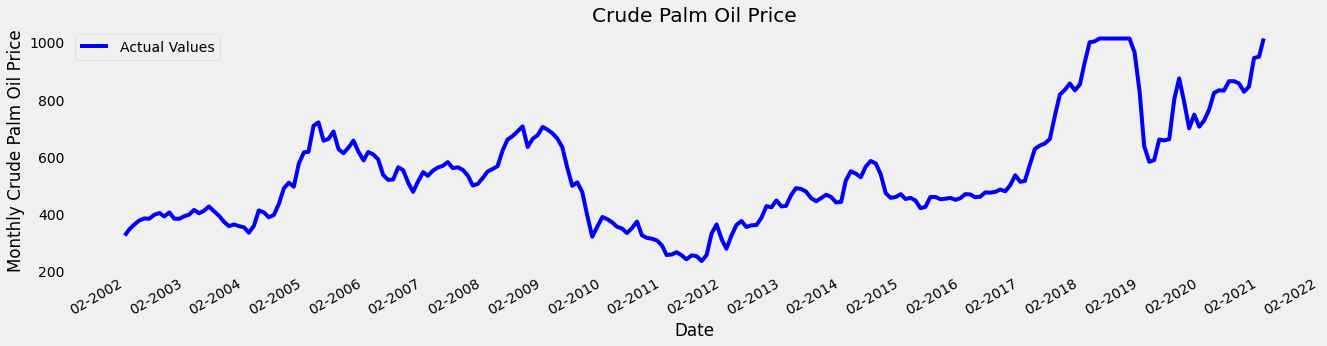

In [103]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(df.index, df['cpo_pri'], color = 'blue',  label = 'Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(['Actual Values', 'Crude Palm Oil Price 2002-2021'],loc='best')
plt.title('Crude Palm Oil Price')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')

####Visualize Multiple Time Series

In [104]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
fig = make_subplots(rows=6, cols=1)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cpo_pri'],name='crude palm oil price'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cno_pri'],name='coconut oil price'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['rps_pri'],name='rapeseed oil price'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['pno_pri'],name='peanut oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['sbo_pri'],name='soybean oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['wti_spri'],name='west texas intermediate spot price'),
    row=4, col=1

)
fig.update_layout(height=1000, width=1200, title_text="Time Series")
fig.show()

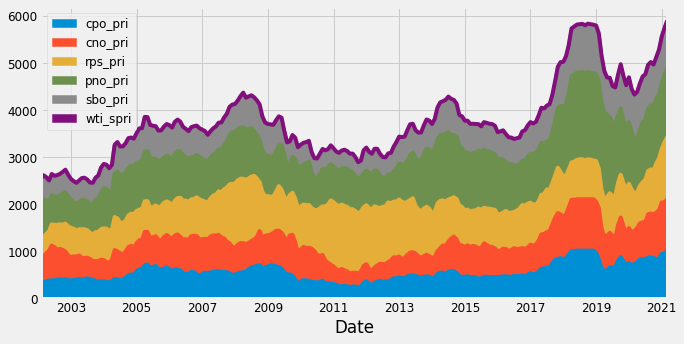

In [105]:
# Plot an area chart
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('Date');
ax.legend(fontsize=12);

####Visualize Correlation Matrices

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 <a list of 6 Text major ticklabel objects>)

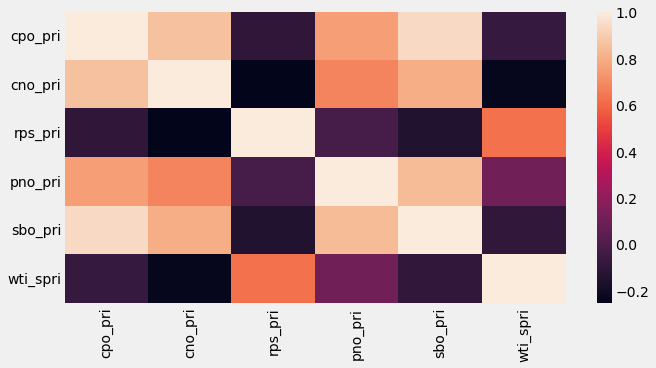

In [90]:
df_corr = df.corr()

sns.heatmap(df_corr)
plt.xticks(rotation=90)
plt.yticks(rotation=0) 

####Clustered Heatmaps

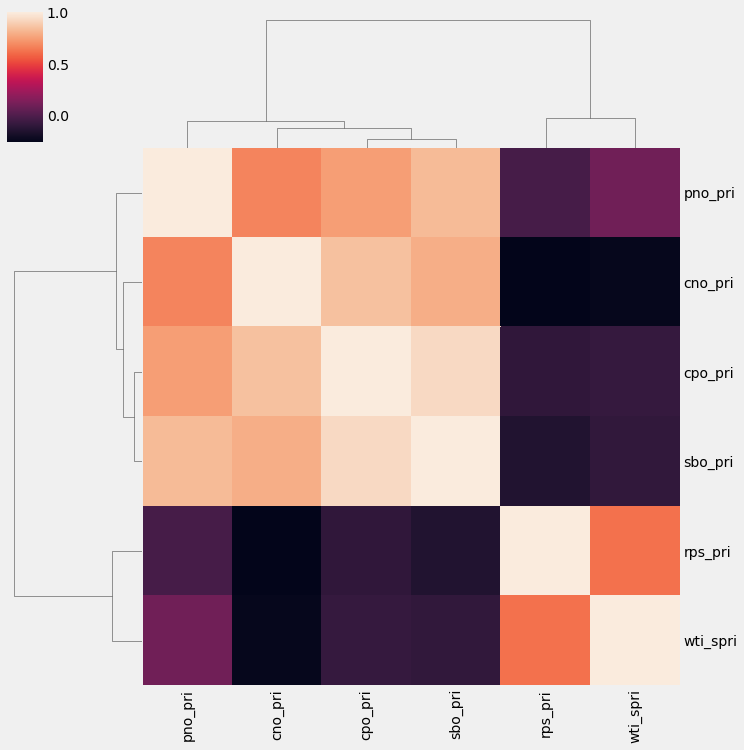

In [91]:
# Get correlation matrix of the meat DataFrame: corr_meat
corr_df = df.corr(method='pearson')

# Customize the heatmap of the corr_meat correlation matrix
fig = sns.clustermap(corr_df,
               row_cluster=True,
               col_cluster=True,
               figsize=(10, 10));

plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90);
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

In [92]:
#Copy the Dataframe
df1 = df.copy()

##Traditional Forecasting Technique

####Split into train and test set

In [106]:
df.reset_index('Date', inplace=True)
df.head()

,Date,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
0,2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
1,2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2,2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
3,2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
4,2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


In [107]:
df.set_index('Date', inplace=True)
split_date = '2016-09' #'2017-06' 
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training months \n {len(df_test)} months of testing data ")
df_training_len = 184

176 days of training months 
 54 months of testing data 


In [ ]:
#X = cleaned_data['cpo_pri']
#test = X.iloc[-46:]
#train = X.iloc[:-46]

In [108]:
#X = df['cpo_pri']
#test = X.iloc[-46:]
#train = X.iloc[:-46]

###Plot the Data: Train Test Split

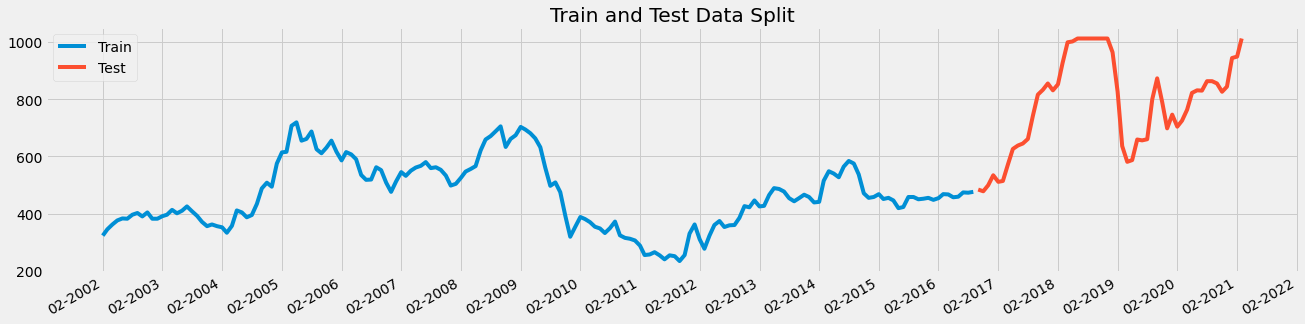

In [109]:
plt.figure(figsize=(20,5))
plt.title("Train and Test Data Split")
plt.plot(df_training.index, df_training['cpo_pri'], label='Train')
plt.plot(df_test.index,df_test['cpo_pri'], label='Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(loc='best')
plt.show()

###Naïve Forecast

We apply the naive forecast to establish a baseline for model accuracy. First, the naive method predicts the time df by continuing the last value. Then, the last value of the last season of the forecast is used according to the seasonal pattern.

In [110]:
y_hat = df_test.copy()
nd = np.asarray(df_training.cpo_pri)
y_hat['naive'] = nd[len(nd)-1]

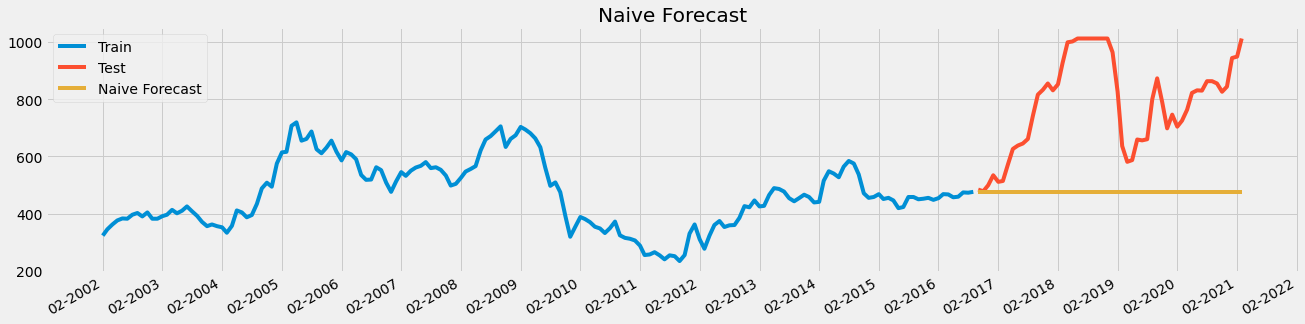

In [111]:
plt.figure(figsize=(20,5))
plt.plot(df_training.index, df_training['cpo_pri'], label='Train')
plt.plot(df_test.index,df_test['cpo_pri'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.savefig('/content/UNF.png')
plt.show()

####Evaluate the Naive Forecast

In [120]:
EVS_NF = explained_variance_score(df_test['cpo_pri'], y_hat['naive'])
print('EVS_NF value of Naive Forecast is:', EVS_NF.round(2))

MAE_NF = mean_absolute_error(df_test['cpo_pri'], y_hat['naive'])
print('MAE value of Naive Forecast is:', MAE_NF.round(2))

MDA_NF = mda(df_test['cpo_pri'], y_hat['naive'])
print('MDA value of the SVR Model is:', round(MDA_NF,2))

MAPE_NF = MAPE(df_test['cpo_pri'], y_hat['naive'])
print('MAPE value Naive of Forecast is', round(MAPE_NF,2))

MSE_NF = mean_squared_error(df_test['cpo_pri'], y_hat['naive'])
print('MSE value of Naive Forecast is:', round(MSE_NF, 2))

RMSE_NF = math.sqrt(mean_squared_error(df_test['cpo_pri'], y_hat['naive']))
print('RMSE value of Naive Forecast is:',  round(RMSE_NF,2))

EVS_NF value of Naive Forecast is: 0.0
MAE value of Naive Forecast is: 309.39
MDA value of the SVR Model is: 0.96
MAPE value Naive of Forecast is 36.37
MSE value of Naive Forecast is: 122394.69
RMSE value of Naive Forecast is: 349.85


###Simple Exponential Smoothing Forecast (SES)

####Applying Grid Search to get Optimal Parameters of Simple Exponential Smoothing Model

In [124]:
resu = []
temp_df = pd.DataFrame()
for i in [0 , 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90,1]:
    print(f'Fitting for smoothing level= {i}')
    fit_v = SimpleExpSmoothing(np.asarray(df_training["cpo_pri"])).fit(i)
    fcst_pred_v= fit_v.forecast(54)
    rmse = np.sqrt(metrics.mean_squared_error(df_test["cpo_pri"], fcst_pred_v))
    df3 = {'smoothing parameter':i, 'RMSE': rmse}
    temp_df = temp_df.append(df3, ignore_index=True)
temp_df.sort_values(by=['RMSE']).head(3)

Fitting for smoothing level= 0
Fitting for smoothing level= 0.1
Fitting for smoothing level= 0.2
Fitting for smoothing level= 0.3
Fitting for smoothing level= 0.4
Fitting for smoothing level= 0.5
Fitting for smoothing level= 0.6
Fitting for smoothing level= 0.7
Fitting for smoothing level= 0.8
Fitting for smoothing level= 0.9
Fitting for smoothing level= 1


,smoothing parameter,RMSE
10,1.0,349.849531
9,0.9,350.119375
8,0.8,350.451144


The least RMSE was achieved with smoothing_level equal to 0.1. Next we utilize it in the same value and train the model.

In [125]:
fitSES = SimpleExpSmoothing(np.asarray(df_training["cpo_pri"])).fit(smoothing_level = 1,optimized= False)
SES_gs_pred = fitSES.forecast(54)

In [128]:
df_test["cpo_pri"]

Date
2016-10-01     484.00
2016-11-01     478.00
2016-12-01     499.00
2017-01-01     534.00
2017-02-01     511.00
2017-03-01     514.00
2017-04-01     572.00
2017-05-01     626.00
2017-06-01     638.00
2017-07-01     645.00
2017-08-01     661.00
2017-09-01     743.00
2017-10-01     816.00
2017-11-01     833.00
2017-12-01     855.00
2018-01-01     831.00
2018-02-01     852.00
2018-03-01     926.00
2018-04-01     999.00
2018-05-01    1002.00
2018-06-01    1012.25
2018-07-01    1012.25
2018-08-01    1012.25
2018-09-01    1012.25
2018-10-01    1012.25
2018-11-01    1012.25
2018-12-01    1012.25
2019-01-01     964.00
2019-02-01     826.00
2019-03-01     636.00
2019-04-01     581.00
2019-05-01     587.00
2019-06-01     659.00
2019-07-01     656.00
2019-08-01     660.00
2019-09-01     800.00
2019-10-01     873.00
2019-11-01     789.00
2019-12-01     698.00
2020-01-01     746.00
2020-02-01     704.00
2020-03-01     725.00
2020-04-01     763.00
2020-05-01     822.00
2020-06-01     831.00
2020-

##Machine Learning Techniques

###Support Vector Regression

In [129]:
#Load Dataframe again to get fresh perspective
df1

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.00,455.000,423.45,844.00,468.00000,28.67
2002-03-01,345.00,546.000,415.85,799.00,485.00000,24.49
2002-04-01,362.00,595.000,410.77,718.00,466.00000,22.06
2002-05-01,376.00,636.000,414.82,614.00,442.00000,21.64
2002-06-01,383.00,738.000,451.04,619.00,429.00000,22.30
...,...,...,...,...,...,...
2020-11-01,826.00,993.000,1047.78,1366.87,860.28000,34.03
2020-12-01,844.00,1031.000,1097.63,1366.87,910.82000,35.50
2021-01-01,944.00,1092.875,1138.24,1383.90,970.08875,35.81


In [130]:
# create fake temperature
df = pd.DataFrame({'temp':np.random.rand(500)})

# define function for create N lags
def create_lags(df, N):
    for i in range(N):
        df['Lag' + str(i+1)] = df.temp.shift(i+1)
    return df

# create 10 lags
df = create_lags(df,10)

# the first 10 days will have missing values. can't use them.
df = df.dropna()

# create X and y
y = df.temp.values
X = df.iloc[:, 1:].values

# Train on 70% of the data
train_idx = int(len(df) * .7)

# create train and test data
X_train, y_train, X_test, y_test = X[:train_idx], y[:train_idx], X[train_idx:], y[:train_idx]

# fit and predict
clf = SVR()
clf.fit(X_train, y_train)

clf.predict(X_test)

array([0.59213242, 0.68194836, 0.22007801, 0.78343255, 0.63999073,
       0.48614684, 0.71415414, 0.48937708, 0.53500163, 0.38754619,
       0.5119702 , 0.41182524, 0.35842651, 0.53974173, 0.55129725,
       0.43695411, 0.55533552, 0.44016285, 0.30244846, 0.48079808,
       0.80952515, 0.39562405, 0.51360407, 0.41095743, 0.3173061 ,
       0.57190412, 0.46111244, 0.38518769, 0.28492203, 0.56450504,
       0.51349917, 0.5113216 , 0.38030239, 0.74630842, 0.74307073,
       0.60644611, 0.47735305, 0.43753564, 0.57376153, 0.41951887,
       0.75749382, 0.82450291, 0.2767825 , 0.84322941, 0.49811819,
       0.48272307, 0.44060672, 0.49515193, 0.62052647, 0.29417526,
       0.61121887, 0.63504435, 0.31360346, 0.45473057, 0.6790068 ,
       0.232219  , 0.54427352, 0.43994054, 0.23038832, 0.39262782,
       0.52951244, 0.62704805, 0.54451343, 0.49631602, 0.63786874,
       0.74969264, 0.48491795, 0.45609465, 0.55069631, 0.48819037,
       0.69097789, 0.46866021, 0.39322052, 0.67882029, 0.53722

In [ ]:
df.set_index('index',inplace=True)

In [ ]:
df.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
index,,,,,,
2002-02-28,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-31,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-30,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-31,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-30,383.0,738.0,451.04,619.0,429.0,22.30


In [ ]:
split_date = '2018-02' #old '2017-06'
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

TypeError: ignored

In [ ]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time df features from datetime index
    """
    df['date'] = df.index
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [ ]:
x = df[['cno_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'wti_spri']]
y = df[['cpo_pri']]

In [ ]:
y.reset_index(drop=True)

,cpo_pri
0,323.00
1,345.00
2,362.00
3,376.00
4,383.00
...,...
225,826.00
226,844.00
227,944.00
228,949.00


###Apply Scaling Function

In [ ]:
scaler_x = MinMaxScaler()   
scaler_y = MinMaxScaler()
print(scaler_x.fit(x))       
xscale=scaler_x.transform(x)
print(scaler_y.fit(y))               
yscale=scaler_y.transform(y)

MinMaxScaler()
MinMaxScaler()


###Split Data into Train, Test Sets:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale, test_size=0.2, random_state=0)

###Support Vector Regression

####Create a GridSearchCV Object and fit it to the Training Data

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100],
             'gamma' :[1, 0.1, 0.01, 0.001,],
             'kernel' :['rbf', 'poly', 'linear','sigmoid'],
              'epsilon': [1e-4, 1e-3]}
scorer = make_scorer(mean_squared_error, greater_is_better=False)
model = SVR()
grid = GridSearchCV(SVR(),param_grid,cv = 10, scoring=scorer, refit = True, verbose =3)
grid.fit(X_train,np.ravel(y_train))
svr_gpred = grid.predict(X_test)
print(grid.best_params_)
#print(grid.best_estimator_)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV 1/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.007 total time=   0.0s
[CV 2/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.004 total time=   0.0s
[CV 3/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.006 total time=   0.0s
[CV 4/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.005 total time=   0.0s
[CV 5/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.006 total time=   0.0s
[CV 6/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.007 total time=   0.0s
[CV 7/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.006 total time=   0.0s
[CV 8/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.004 total time=   0.0s
[CV 9/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.007 total time=   0.0s
[CV 10/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.004 total time=   0.0s
[CV 1/10] END C=0.1, epsil

SVR Best Parameters are:
* C: 10
* epsilon: 0.001
* gamma: 1
* kernel: rbf 

In [ ]:
testY = scaler_y.inverse_transform(y_test)
testY2 = pd.DataFrame(testY, columns = ['Predictions'])
testY2.head()

,Predictions
0,443.00
1,1012.25
2,323.00
3,661.00
4,466.00


In [ ]:
svr_gprediction = np.reshape(svr_gpred, (-1,1))
svr_gprediction = scaler_y.inverse_transform(svr_gprediction)
svr_prediction = pd.DataFrame(svr_gprediction, columns = ['Predictions'])
svr_prediction

,Predictions
0,440.559860
1,1009.202464
2,301.601396
3,696.175818
4,444.920879
5,406.358818
6,764.548713
7,595.182321
8,780.530763
9,480.154403


####Plot train, test and forecast

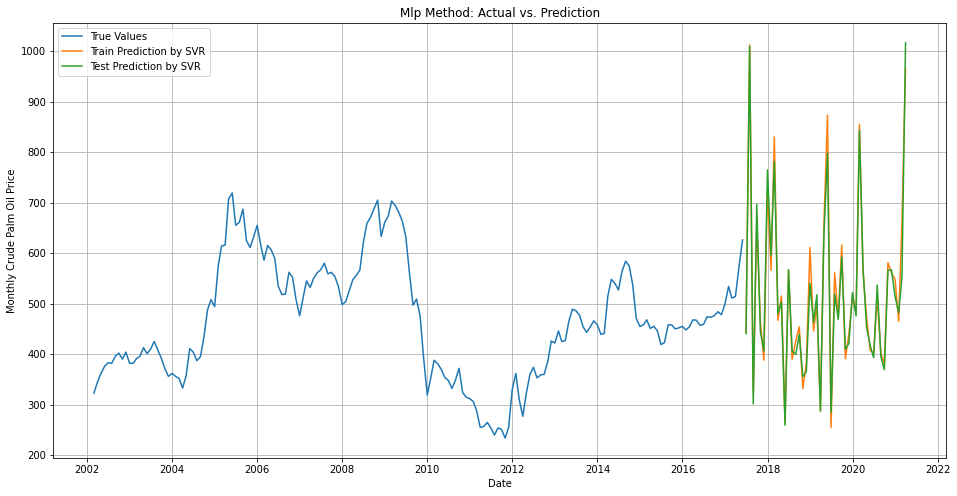

In [ ]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_training.index, df_training.cpo_pri, label = 'Train')
plt.plot(df_test.index, testY2,  label = 'Test')
plt.plot(df_test.index, svr_prediction,label = 'SVR Prediction')
plt.legend(['True Values', 'Train Prediction by SVR', 'Test Prediction by SVR'],loc='best')
plt.title('Mlp Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

####SVR Prediction Plot Zoomed-In
Zoom in to a closer timeframe

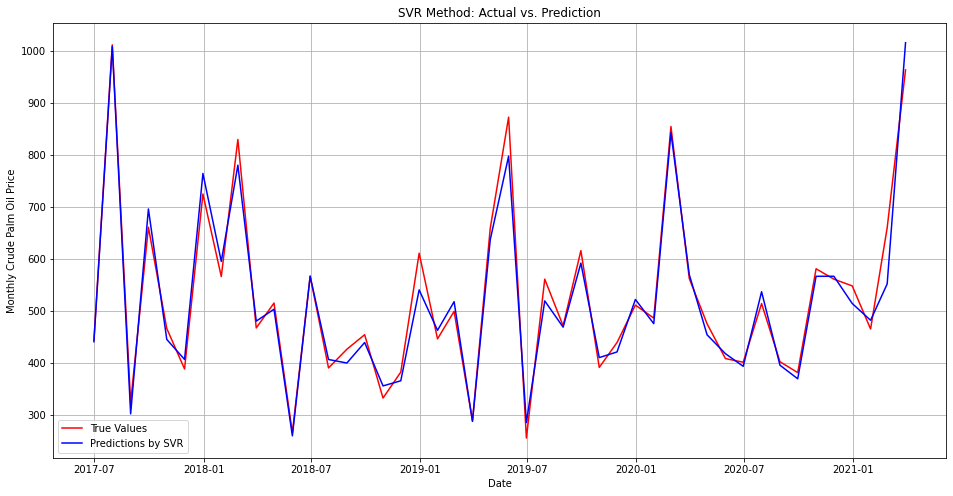

In [ ]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_test.index, testY2, color = 'red',  label = 'Test')
plt.plot(df_test.index,  svr_prediction, color = 'blue',label = 'SVR Prediction')
plt.legend(['True Values', 'Predictions by SVR', 'SVR Prediction'],loc='best')
plt.title('SVR Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

####Accuracy and Precision the Suppor Vector Regression

In [ ]:
MAE_svr = mean_absolute_error(testY2, svr_prediction)
print('MAE value of the SVR Model is:', MAE_svr)

MDA_svr = mda(testY2, svr_prediction)
print('MDA value of the SVR Model is:', *MDA_svr)

MAPE_svr = mean_absolute_percentage_error(testY2, svr_prediction)
print('MAPE value of the SVR Model is:', MAPE_svr)

RMSE_svr = mean_squared_error(testY2,svr_prediction, squared=False)
print('RMSE value of the SVR Model is:', RMSE_svr)

MSE_svr = mean_squared_error(testY2,svr_prediction)
print('MSE value of the SVR Model is:', MSE_svr)

MAE value of the SVR Model is: 22.615709233845653
MDA value of the SVR Model is: 0.9565217391304348
MAPE value of the SVR Model is: 4.2424465551087875
RMSE value of the SVR Model is: 30.656818356487694
MSE value of the SVR Model is: 939.8405117426809


###Define MLPRegression pipeline

In [ ]:
pipe_MLPRegressor = Pipeline([('scaler',  MinMaxScaler()),
            ('MLPRegressor', MLPRegressor(random_state = 42))])

###Apply Grid Search to MLP Model

In [ ]:
grid_params_MLPRegressor = [{
    'MLPRegressor__solver': ['sgd', 'adam'],
    'MLPRegressor__alpha': [0.0001, 0.05],
    'MLPRegressor__max_iter': [100,200,300, 500, 1000],
    'MLPRegressor__activation' : ['relu','logistic','tanh'],
    'MLPRegressor__learning_rate' : ['constant', 'adaptive'],
    'MLPRegressor__hidden_layer_sizes':[(50,50,50), (50,100,50), (100,)],}]


CV_mlpregressor_grid = GridSearchCV (estimator = pipe_MLPRegressor,
                               param_grid = grid_params_MLPRegressor, n_jobs=-1,
                               cv = 5,return_train_score=True, verbose=0)


#CV_mlpregressor_grid.fit(X_train, y_train)

CV_mlpregressor_grid.fit(X_train, np.ravel(y_train))

ypred=CV_mlpregressor_grid.predict(X_test)

print (np.c_[y_test, ypred])
print('Best Parameters : ',CV_mlpregressor_grid.best_params_)

[[0.26855124 0.24206006]
 [1.         0.90593157]
 [0.11435914 0.10433442]
 [0.54866688 0.59790512]
 [0.29810472 0.26312596]
 [0.19787986 0.29682895]
 [0.63090267 0.68987568]
 [0.42659814 0.44497244]
 [0.76582075 0.75638406]
 [0.29938966 0.32679554]
 [0.3610665  0.32406574]
 [0.03983296 0.04254538]
 [0.42788307 0.43882256]
 [0.20044973 0.23139749]
 [0.24670736 0.2214183 ]
 [0.28268551 0.24197102]
 [0.12592355 0.19009682]
 [0.19017025 0.24016516]
 [0.48442017 0.37689951]
 [0.27240604 0.36024887]
 [0.34050755 0.40347935]
 [0.06938644 0.02807012]
 [0.54609701 0.59372758]
 [0.82107292 0.76264894]
 [0.02698362 0.03600115]
 [0.42017347 0.42960394]
 [0.30452939 0.40259244]
 [0.49084484 0.4154426 ]
 [0.20173466 0.13107019]
 [0.2634115  0.20391347]
 [0.35592676 0.38788109]
 [0.32380341 0.31022683]
 [0.79794411 0.80966504]
 [0.4214584  0.47728078]
 [0.30966913 0.41264775]
 [0.22357854 0.0954725 ]
 [0.214584   0.11797549]
 [0.35978156 0.41021765]
 [0.21586894 0.2240394 ]
 [0.18888532 0.27678374]


In [ ]:
'''
GridSearchCV(cv=5, estimator=MLPRegressor(random_state=42), n_jobs=-1,
             param_grid={'activation': ['relu', 'identity', 'tanh', 'logistic'],
                         'hidden_layer_sizes': [50, 100, 150, (50, 100),
                                                (50, 150), (100, 50),
                                                (100, 150), (150, 50),
                                                (150, 100), (50, 100, 150),
                                                (50, 150, 100), (100, 50, 150),
                                                (100, 150, 50), (150, 50, 100),
                                                (150, 100, 50)],
                         'learning_rate': ['constant', 'adaptive',
                                           'invscaling'],
                         'solver': ['lbfgs', 'adam']},
             verbose=10)
'''

"\nGridSearchCV(cv=5, estimator=MLPRegressor(random_state=42), n_jobs=-1,\n             param_grid={'activation': ['relu', 'identity', 'tanh', 'logistic'],\n                         'hidden_layer_sizes': [50, 100, 150, (50, 100),\n                                                (50, 150), (100, 50),\n                                                (100, 150), (150, 50),\n                                                (150, 100), (50, 100, 150),\n                                                (50, 150, 100), (100, 50, 150),\n                                                (100, 150, 50), (150, 50, 100),\n                                                (150, 100, 50)],\n                         'learning_rate': ['constant', 'adaptive',\n                                           'invscaling'],\n                         'solver': ['lbfgs', 'adam']},\n             verbose=10)\n"

MLP Output/Best Parameters

* MLPRegressor__activation: 'tanh'
* MLPRegressor__alpha: 0.05
* MLPRegressor__hidden_layer_sizes: (50, 50, 50)
* MLPRegressor__learning_rate: 'constant'
* MLPRegressor__max_iter: 100
* MLPRegressor__solver: 'adam'



In [ ]:
model = Sequential()
model.add(Dense(5, input_dim=5, kernel_initializer='normal', activation='tanh')) #old:12/5
model.add(Dense(5, activation='tanh')) # old:8
model.add(Dense(1, activation='tanh'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12)                72        
                                                                 
 dense_4 (Dense)             (None, 8)                 104       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=50,  verbose=1, validation_split=0.2)

Epoch 1/250
3/3 [==============================] - 1s 83ms/step - loss: 0.1098 - mse: 0.1098 - mae: 0.2687 - val_loss: 0.1282 - val_mse: 0.1282 - val_mae: 0.3021
Epoch 2/250
3/3 [==============================] - 0s 11ms/step - loss: 0.0799 - mse: 0.0799 - mae: 0.2186 - val_loss: 0.0948 - val_mse: 0.0948 - val_mae: 0.2513
Epoch 3/250
3/3 [==============================] - 0s 11ms/step - loss: 0.0579 - mse: 0.0579 - mae: 0.1786 - val_loss: 0.0699 - val_mse: 0.0699 - val_mae: 0.2090
Epoch 4/250
3/3 [==============================] - 0s 12ms/step - loss: 0.0441 - mse: 0.0441 - mae: 0.1510 - val_loss: 0.0527 - val_mse: 0.0527 - val_mae: 0.1779
Epoch 5/250
3/3 [==============================] - 0s 13ms/step - loss: 0.0349 - mse: 0.0349 - mae: 0.1388 - val_loss: 0.0424 - val_mse: 0.0424 - val_mae: 0.1675
Epoch 6/250
3/3 [==============================] - 0s 11ms/step - loss: 0.0316 - mse: 0.0316 - mae: 0.1368 - val_loss: 0.0366 - val_mse: 0.0366 - val_mae: 0.1625
Epoch 7/250
3/3 [===========

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


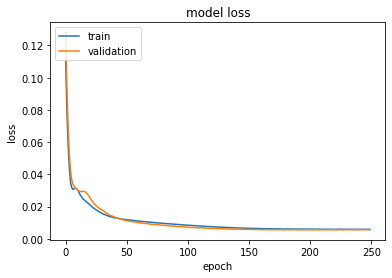

In [ ]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

###Invert Transformed Data

In [ ]:
ypred = model.predict(X_test)
mlp_pred = scaler_y.inverse_transform(ypred)
MLP_predictions = pd.DataFrame(mlp_pred, columns = ['Predictions'])
testY = scaler_y.inverse_transform(y_test)
testY2 = pd.DataFrame(testY, columns = ['Predictions'])
testY2.head()

,Predictions
0,443.00
1,1012.25
2,323.00
3,661.00
4,466.00


In [ ]:
ActPred = pd.DataFrame(np.concatenate([testY, mlp_pred], axis=1), columns= ['Actual','MLP Predicted'])

In [ ]:
ActPred

,Actual,MLP Predicted
0,443.00,431.906799
1,1012.25,844.826660
2,323.00,321.206451
3,661.00,709.909424
4,466.00,426.018677
5,388.00,418.724731
6,725.00,797.027588
7,566.00,629.755432
8,830.00,814.885010
9,467.00,489.931213


###Plot train, test and forecast MLP

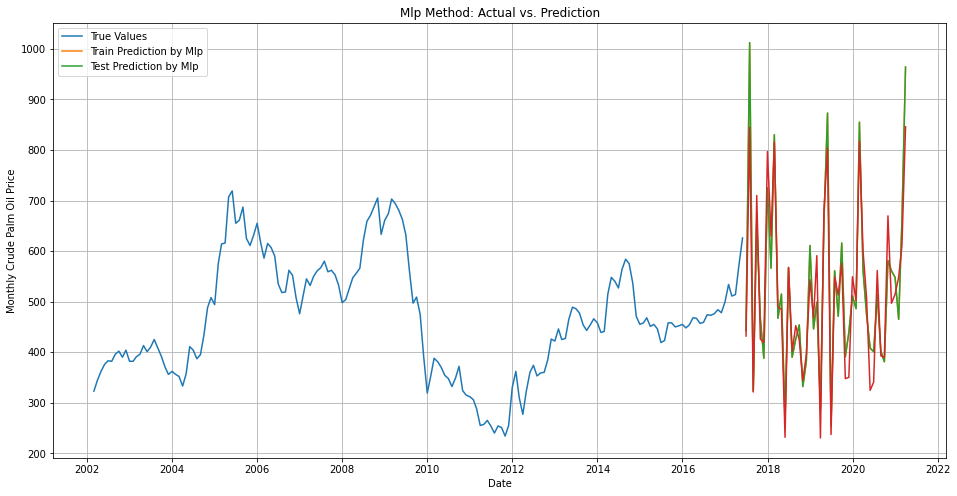

In [ ]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_training.index, df_training.cpo_pri, label = 'Train')
plt.plot(df_test.index, testY2,  label = 'Test')
plt.plot(df_test.index, ActPred,label = 'MLP Prediction')
plt.legend(['True Values', 'Train Prediction by Mlp', 'Test Prediction by Mlp'],loc='best')
plt.title('Mlp Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

###MLP Prediction Plot Zoomed-In

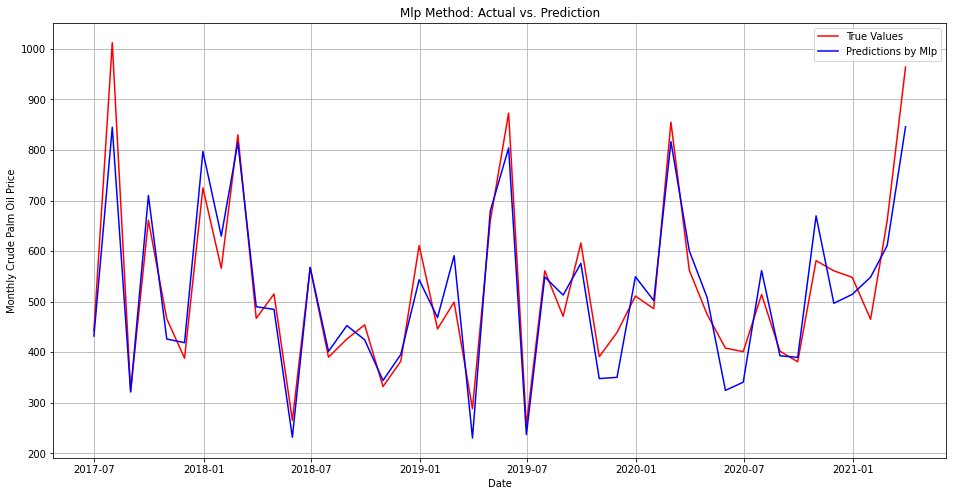

In [ ]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_test.index, testY2, color = 'red',  label = 'Test')
plt.plot(df_test.index,  MLP_predictions, color = 'blue',label = 'MLP Prediction')
plt.legend(['True Values', 'Predictions by Mlp', 'MLP Prediction'],loc='best')
plt.title('Mlp Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

###Accuracy and Precision the Multilayer Perceptron

In [ ]:
MAE_mlp = mean_absolute_error(testY2, MLP_predictions)
print('MAE value of the MLP Model is:', MAE_mlp)

MDA_mlp = mda(testY2, MLP_predictions)
print("MDA value of the MLP Model is:", *MDA_mlp)

MAPE_mlp = mean_absolute_percentage_error(testY2, MLP_predictions)
print('MAPE value of the MLP Model is:', MAPE_mlp)

RMSE_mlp = mean_squared_error(testY2, MLP_predictions, squared=False)
print('RMSE value of the MLP Model is:', RMSE_mlp)

MSE_mlp = mean_squared_error(testY2, MLP_predictions)
print('MSE value of the MLP Model is:', MSE_mlp)

MAE value of the MLP Model is: 43.83291426948879
MDA value of the MLP Model is: 0.9565217391304348
MAPE value of the MLP Model is: 8.336063677079041
RMSE value of the MLP Model is: 54.800247630836736
MSE value of the MLP Model is: 3003.0671404010272


**OLD**
MAE value of the MLP Model is: 43.83291426948879
MDA value of the MLP Model is: 0.9565217391304348
MAPE value of the MLP Model is: 8.336063677079041
RMSE value of the MLP Model is: 54.800247630836736
MSE value of the MLP Model is: 3003.0671404010272

In [ ]:
#####################################################################################################
# RNN

In [ ]:
from sklearn import datasets, linear_model
from keras.layers import Dense, Dropout, Flatten
from keras.constraints import maxnorm
from sklearn.model_selection import cross_val_score, KFold
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
seed = 1 

In [ ]:
X = df[['cno_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'wti_spri']]
y = np.array(df[['cpo_pri']])

In [ ]:
input_dim = 5
print(input_dim) # 5

5


In [ ]:
def create_model():
    # default values
    activation='relu' # or linear
    dropout_rate=0.0 # or 0.2
    init_mode='uniform'
    weight_constraint=0 # or  4
    optimizer='adam' # or SGD
    lr = 0.01
    momemntum=0
    # create model
    model = Sequential()
    model.add(Dense(5, 
                    input_dim=input_dim, kernel_initializer=init_mode, 
                    activation=activation,
                    kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate)) 
    model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
    # Compile model
    model.compile(loss='mae', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    return model

# create model
model = KerasRegressor(build_fn=create_model, batch_size=1000, epochs=10) 
# use verbose=0 if you do not want to see progress

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [ ]:
########################################################
# Use scikit-learn to grid search 
activation =  ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'] # softmax, softplus, softsign 
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
weight_constraint=[1, 2, 3, 4, 5]
neurons = [1, 5, 10, 15, 20, 25, 30]
init = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
optimizer = [ 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

In [ ]:
##############################################################
# grid search epochs, batch size
epochs = [1, 10, 50, 100] # add 50, 100, 150 etc
batch_size = [5, 10, 20, 40, 60, 80, 100] # add 5, 10, 20, 40, 60, 80, 100 etc
param_grid = dict(epochs=epochs, batch_size=batch_size)

In [ ]:
##############################################################
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X,y) 
##############################################################

Epoch 1/50
46/46 [==============================] - 0s 2ms/step - loss: 539.7878 - accuracy: 0.0000e+00
Epoch 2/50
46/46 [==============================] - 0s 2ms/step - loss: 539.7650 - accuracy: 0.0000e+00
Epoch 3/50
46/46 [==============================] - 0s 2ms/step - loss: 539.7517 - accuracy: 0.0000e+00
Epoch 4/50
46/46 [==============================] - 0s 2ms/step - loss: 539.7358 - accuracy: 0.0000e+00
Epoch 5/50
46/46 [==============================] - 0s 2ms/step - loss: 539.7166 - accuracy: 0.0000e+00
Epoch 6/50
46/46 [==============================] - 0s 2ms/step - loss: 539.6942 - accuracy: 0.0000e+00
Epoch 7/50
46/46 [==============================] - 0s 2ms/step - loss: 539.6691 - accuracy: 0.0000e+00
Epoch 8/50
46/46 [==============================] - 0s 2ms/step - loss: 539.6421 - accuracy: 0.0000e+00
Epoch 9/50
46/46 [==============================] - 0s 2ms/step - loss: 539.6140 - accuracy: 0.0000e+00
Epoch 10/50
46/46 [==============================] - 0s 2ms/step

In [ ]:
##############################################################
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -539.292639 using {'batch_size': 5, 'epochs': 50}
-539.772949 (163.002788) with: {'batch_size': 5, 'epochs': 1}
-539.661249 (162.978963) with: {'batch_size': 5, 'epochs': 10}
-539.292639 (163.002061) with: {'batch_size': 5, 'epochs': 50}
-539.295752 (162.997122) with: {'batch_size': 5, 'epochs': 100}
-539.777460 (163.002611) with: {'batch_size': 10, 'epochs': 1}
-539.726404 (163.001302) with: {'batch_size': 10, 'epochs': 10}
-539.388458 (163.021046) with: {'batch_size': 10, 'epochs': 50}
-539.349939 (163.040197) with: {'batch_size': 10, 'epochs': 100}
-539.780103 (163.002658) with: {'batch_size': 20, 'epochs': 1}
-539.755823 (163.003135) with: {'batch_size': 20, 'epochs': 10}
-539.557782 (163.044771) with: {'batch_size': 20, 'epochs': 50}
-539.356732 (162.976593) with: {'batch_size': 20, 'epochs': 100}
-539.781305 (163.002637) with: {'batch_size': 40, 'epochs': 1}
-539.769611 (163.002940) with: {'batch_size': 40, 'epochs': 10}
-539.693182 (162.975244) with: {'batch_size': 40, 'ep

In [ ]:
GridSearchCV(cv=5, estimator=baseline_model, n_jobs=-1,
             param_grid={'activation': ['relu', 'identity', 'tanh', 'logistic'],
                         'hidden_layer_sizes': [50, 100, 150, (50, 100),
                                                (50, 150), (100, 50),
                                                (100, 150), (150, 50),
                                                (150, 100), (50, 100, 150),
                                                (50, 150, 100), (100, 50, 150),
                                                (100, 150, 50), (150, 50, 100),
                                                (150, 100, 50)],
                         'learning_rate': ['constant', 'adaptive',
                                           'invscaling'],
                         'solver': ['lbfgs', 'adam']},
             verbose=10)

#GridSearchCV(estimator=baseline_model, param_grid=param_grid, n_jobs=-1)

GridSearchCV(cv=5, estimator=<function baseline_model at 0x7f62015fea70>,
             n_jobs=-1,
             param_grid={'activation': ['relu', 'identity', 'tanh', 'logistic'],
                         'hidden_layer_sizes': [50, 100, 150, (50, 100),
                                                (50, 150), (100, 50),
                                                (100, 150), (150, 50),
                                                (150, 100), (50, 100, 150),
                                                (50, 150, 100), (100, 50, 150),
                                                (100, 150, 50), (150, 50, 100),
                                                (150, 100, 50)],
                         'learning_rate': ['constant', 'adaptive',
                                           'invscaling'],
                         'solver': ['lbfgs', 'adam']},
             verbose=10)

In [ ]:
def baseline_model():
    model = Sequential()
    model.add(Dense(5, input_dim=5, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
# Use scikit-learn to grid search 
activation =  ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'] # softmax, softplus, softsign 
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
weight_constraint=[1, 2, 3, 4, 5]
neurons = [1, 5, 10, 15, 20, 25, 30]
init = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
optimizer = [ 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

In [ ]:
# grid search epochs, batch size
epochs = [1, 10] # add 50, 100, 150 etc
batch_size = [1000, 5000] # add 5, 10, 20, 40, 60, 80, 100 etc
param_grid = dict(epochs=epochs, batch_size=batch_size)

In [ ]:
grid = GridSearchCV(estimator=baseline_model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X,y) 

TypeError: ignored

In [ ]:
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=100, verbose=False)
kfold = KFold(n_splits=10, random_state=None)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))
estimator.fit(X, y)
prediction = estimator.predict(X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


Results: -2173467.39 (3313375.22) MSE


In [ ]:
prediction = estimator.predict(X)
prediction

array([137.92558, 137.55106, 134.18709, 130.80394, 143.0881 , 144.45842,
       146.78502, 149.81392, 153.1086 , 156.90895, 155.90654, 153.02109,
       145.6549 , 140.56737, 140.51799, 149.29158, 149.2753 , 145.28734,
       139.0138 , 138.4713 , 150.24242, 154.05862, 162.39111, 172.73988,
       172.67267, 167.60388, 163.36395, 186.44734, 189.74716, 183.84283,
       184.65747, 186.08026, 189.9438 , 192.27734, 195.09525, 192.5296 ,
       186.97821, 192.52957, 193.65845, 192.67558, 188.06073, 188.13281,
       188.39415, 192.92392, 198.50452, 202.00177, 201.93726, 206.27   ,
       204.31429, 209.23866, 216.08383, 222.75615, 222.6442 , 220.11082,
       217.20488, 214.87146, 215.57053, 224.70596, 227.67236, 219.11378,
       210.59439, 207.97441, 215.09283, 221.53654, 222.19507, 232.35036,
       235.229  , 248.74742, 262.07642, 280.74405, 294.8521 , 296.54315,
       299.88336, 299.6989 , 298.6809 , 295.81403, 293.91708, 292.37662,
       286.35272, 272.56003, 252.70747, 241.91032, 

In [ ]:
##########################################################################################################################

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x1, y1)

In [ ]:
y_train=np.reshape(y_train, (-1,1))
y_val=np.reshape(y_val, (-1,1))
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
print(scaler_x.fit(X_train))
xtrain_scale=scaler_x.transform(X_train)
print(scaler_x.fit(X_val))
xval_scale=scaler_x.transform(X_val)
print(scaler_y.fit(y_train))
ytrain_scale=scaler_y.transform(y_train)
print(scaler_y.fit(y_val))
yval_scale=scaler_y.transform(y_val)

MinMaxScaler()
MinMaxScaler()
MinMaxScaler()
MinMaxScaler()


In [ ]:
#Grid search
grid_params_MLPRegressor = [{
    'MLPRegressor__solver': ['sgd', 'adam'],
    'MLPRegressor__alpha': [0.0001, 0.05],
    'MLPRegressor__max_iter': [100,200,300, 500, 1000],
    'MLPRegressor__activation' : ['relu','logistic','tanh'],
    'MLPRegressor__learning_rate' : ['constant', 'adaptive'],
    'MLPRegressor__hidden_layer_sizes':[(50,50,50), (50,100,50), (100,)],}]

In [ ]:
model = Sequential()
model.add(Dense(5, input_dim=5, kernel_initializer='normal', activation='relu'))
model.add(Dense(1150, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 5)                 30        
                                                                 
 dense_10 (Dense)            (None, 1150)              6900      
                                                                 
 dense_11 (Dense)            (None, 1)                 1151      
                                                                 
Total params: 8,081
Trainable params: 8,081
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
history=model.fit(xtrain_scale, ytrain_scale, epochs=30, batch_size=150, verbose=1, validation_split=0.2)
predictions = model.predict(xval_scale)

Epoch 1/30
1/1 [==============================] - 1s 599ms/step - loss: 0.2119 - mse: 0.2119 - mae: 0.3939 - val_loss: 0.1757 - val_mse: 0.1757 - val_mae: 0.3614
Epoch 2/30
1/1 [==============================] - 0s 32ms/step - loss: 0.1927 - mse: 0.1927 - mae: 0.3693 - val_loss: 0.1591 - val_mse: 0.1591 - val_mae: 0.3418
Epoch 3/30
1/1 [==============================] - 0s 32ms/step - loss: 0.1757 - mse: 0.1757 - mae: 0.3474 - val_loss: 0.1437 - val_mse: 0.1437 - val_mae: 0.3225
Epoch 4/30
1/1 [==============================] - 0s 34ms/step - loss: 0.1598 - mse: 0.1598 - mae: 0.3257 - val_loss: 0.1287 - val_mse: 0.1287 - val_mae: 0.3022
Epoch 5/30
1/1 [==============================] - 0s 28ms/step - loss: 0.1444 - mse: 0.1444 - mae: 0.3035 - val_loss: 0.1143 - val_mse: 0.1143 - val_mae: 0.2807
Epoch 6/30
1/1 [==============================] - 0s 34ms/step - loss: 0.1295 - mse: 0.1295 - mae: 0.2817 - val_loss: 0.1006 - val_mse: 0.1006 - val_mae: 0.2581
Epoch 7/30
1/1 [=================

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


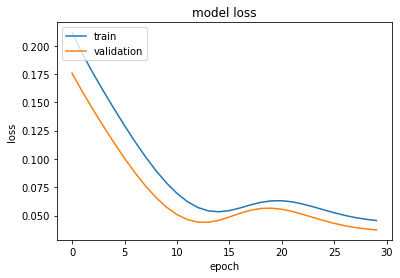

In [ ]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions = scaler_y.inverse_transform(predictions)
predictions

array([[536.4475 ],
       [547.6313 ],
       [604.8438 ],
       [548.039  ],
       [525.06305],
       [516.21484],
       [549.2116 ],
       [586.03   ],
       [603.2041 ],
       [611.8776 ],
       [534.4038 ],
       [545.34106],
       [611.8022 ],
       [537.63354],
       [527.63086],
       [544.4875 ],
       [556.25867],
       [551.87244],
       [575.29156],
       [526.301  ],
       [545.851  ],
       [530.06036],
       [542.44836],
       [524.2276 ],
       [546.48254],
       [548.0777 ],
       [535.6315 ],
       [548.2    ],
       [577.3203 ],
       [544.0516 ],
       [543.8167 ],
       [555.0335 ],
       [544.7712 ],
       [579.9567 ],
       [541.31024],
       [521.9905 ],
       [514.2243 ],
       [542.9846 ],
       [552.3525 ],
       [524.53357],
       [536.57294],
       [537.79004],
       [552.6294 ],
       [532.4163 ],
       [548.77747],
       [514.15424],
       [524.2036 ],
       [612.01263],
       [540.11206],
       [602.84546],


In [ ]:
len(df_test.index)

46

In [ ]:
ActPred2 = pd.DataFrame(np.concatenate([y_val, predictions], axis=1), columns= ['Actual','NN_Predicted'])

In [ ]:
ActPred2

,Actual,NN_Predicted
0,288.00,536.447510
1,452.00,547.631287
2,949.00,604.843811
3,504.00,548.039001
4,390.00,525.063049
5,410.00,516.214844
6,515.00,549.211609
7,855.00,586.030029
8,944.00,603.204102
9,1012.25,611.877625


ValueError: ignored

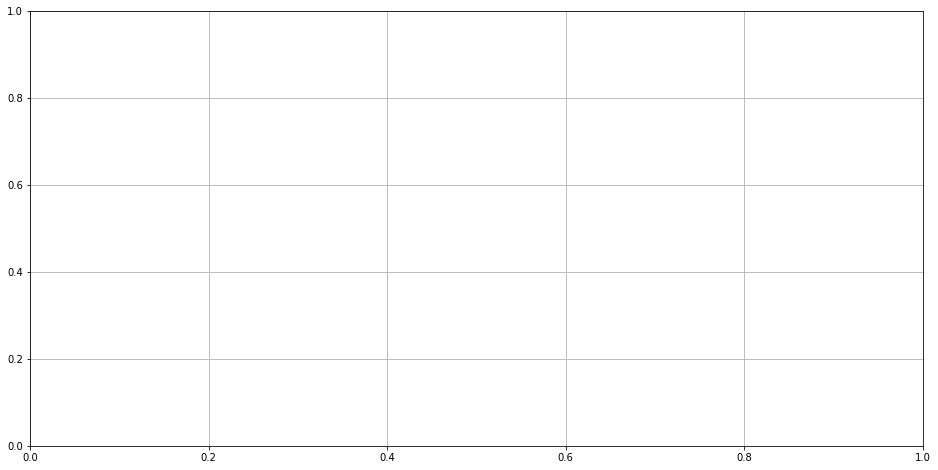

In [ ]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df.index, y_val, color = 'red',  label = 'Test')
plt.plot(df.index,  ActPred2, color = 'blue',label = 'MLP Prediction')
plt.legend(['True Values', 'Predictions by Mlp', 'MLP Prediction'],loc='best')
plt.title('Mlp Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
def build_regressor(optimizer='adam', lr=0.001):
  regressor = Sequential()
  regressor.add(Dense(units = 5 , kernel_initializer='random_uniform', activation= 'relu'))
  regressor.add(Dense(units = 5 , kernel_initializer='random_uniform', activation= 'relu'))
  regressor.add(Dense(units = 1 , kernel_initializer='random_uniform', activation= 'sigmoid'))
  regressor.compile(optimizer=optimizer , loss = 'mse', 
  metrics=['accuracy'])
  return regressor
KR = KerasRegressor(build_fn=build_regressor)
parameters = {'batch_size' : [10,30],
              'lr' : [0.001, 0.1],
          'epochs' : [50,100],
          'optimizer':['adam','SGD']}
grid_search = GridSearchCV(estimator = KR, param_grid = parameters, n_jobs=-1, scoring='accuracy',cv=5, return_train_score=True, verbose=0)
grid_search.fit(X_train,y_train)

grid_search.fit(X_train, np.ravel(y_train))

ypred = grid_search.predict(X_test)

print ([y_test, ypred])
print('Best Parameters : ',grid_search.best_params_)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  # This is added back by InteractiveShellApp.init_path()


15/15 [==============================] - 1s 2ms/step - loss: 0.0716 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0706 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0701 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0683 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0676 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0667 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0658 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 2ms/step - loss: 0.0719 - accuracy: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0707 - accuracy: 0.0000e+00
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0701 - accuracy: 0.0000e+00
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0695 - accuracy: 0.0000e+00
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0688 - accuracy: 0.0000e+00
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0683 - accuracy: 0.0000e+00
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0674 - accuracy: 0.0000e+00
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0667 - accuracy: 0.0000e+00
Epoch 10/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0658 - accuracy: 0

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 2ms/step - loss: 0.0653 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0646 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0639 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0632 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0624 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0617 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0609 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0601 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0594 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0586 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 2ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0685 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0678 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0671 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0662 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0639 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0625 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0611 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 2ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0691 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0682 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0673 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0664 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0656 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0634 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0624 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0717 - accuracy: 0.0136
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0714 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0700 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0720 - accuracy: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0717 - accuracy: 0.0000e+00
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0710 - accuracy: 0.0000e+00
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0707 - accuracy: 0.0000e+00
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0704 - accuracy: 0.0000e+00
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0701 - accuracy: 0.0000e+00
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.0000e+00
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0696 - accuracy: 0.0000e+00
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0693 - accuracy: 0

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0654 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0641 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0636 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0632 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0628 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0625 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0621 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0618 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 3ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0695 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0689 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0686 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 83s 2ms/step - loss: 0.0684 - accuracy: 0.0068  
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0679 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0677 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0675 - accuracy: 0.0068
Epoch 11/50
15/15 [========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0685 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0677 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0673 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0669 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 2ms/step - loss: 0.0715 - accuracy: 0.0136
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0706 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0685 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0679 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0673 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0719 - accuracy: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0712 - accuracy: 0.0000e+00
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0706 - accuracy: 0.0000e+00
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0700 - accuracy: 0.0000e+00
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0693 - accuracy: 0.0000e+00
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0686 - accuracy: 0.0000e+00
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0678 - accuracy: 0.0000e+00
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0670 - accuracy: 0.0000e+00
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0661 - accuracy: 0.0000e+00
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0652 - accuracy: 0

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 2ms/step - loss: 0.0653 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0630 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0622 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0613 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0604 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0595 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0585 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0573 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0695 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0688 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0683 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0676 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0669 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0662 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0653 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0643 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0632 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0619 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 2ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0687 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0678 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0667 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0653 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0618 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0597 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0717 - accuracy: 0.0340
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0714 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0700 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0720 - accuracy: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0717 - accuracy: 0.0000e+00
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0710 - accuracy: 0.0000e+00
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0707 - accuracy: 0.0000e+00
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0704 - accuracy: 0.0000e+00
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0701 - accuracy: 0.0000e+00
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0698 - accuracy: 0.0000e+00
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0696 - accuracy: 0.0000e+00
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0693 - accuracy: 0

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 3ms/step - loss: 0.0654 - accuracy: 0.0136
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0640 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0636 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0632 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0628 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0625 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0621 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0618 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0689 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0687 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0684 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0679 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0677 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0675 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0685 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0677 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0673 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0669 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 2ms/step - loss: 0.0716 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0710 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0689 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0680 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0669 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0656 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0641 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0623 - accuracy: 0.0068
Epoch 11/100
15/15 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 2ms/step - loss: 0.0718 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0712 - accuracy: 0.0000e+00
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0703 - accuracy: 0.0000e+00
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0694 - accuracy: 0.0000e+00
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0683 - accuracy: 0.0000e+00
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0670 - accuracy: 0.0000e+00
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0655 - accuracy: 0.0000e+00
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0637 - accuracy: 0.0000e+00
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0617 - accuracy: 0.0000e+00
Epoch 10/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0593 - accura

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 2ms/step - loss: 0.0652 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0636 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0627 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0616 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0605 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0593 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0579 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0567 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0553 - accuracy: 0.0068
Epoch 11/100
15/15 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 2ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0688 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0683 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0679 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0675 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0671 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0668 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0665 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0661 - accuracy: 0.0068
Epoch 11/100
15/15 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0708 - accuracy: 0.0000e+00
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0700 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0682 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0672 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0660 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0646 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0628 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0610 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0590 - accuracy: 0.0068
Epoch 11/100
15/1

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0717 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0714 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0712 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0700 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 11/100
15/15 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0720 - accuracy: 0.0000e+00
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0717 - accuracy: 0.0000e+00
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0710 - accuracy: 0.0000e+00
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0707 - accuracy: 0.0000e+00
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0704 - accuracy: 0.0000e+00
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0701 - accuracy: 0.0000e+00
Epoch 8/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0698 - accuracy: 0.0000e+00
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0696 - accuracy: 0.0000e+00
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0693 - ac

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0654 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0640 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0636 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0632 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0628 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0625 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0621 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0618 - accuracy: 0.0068
Epoch 11/100
15/15 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0689 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0686 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0684 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0679 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0677 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0675 - accuracy: 0.0068
Epoch 11/100
15/15 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0685 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0677 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0673 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0669 - accuracy: 0.0068
Epoch 11/100
15/15 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0715 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0710 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0706 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0693 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0686 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0679 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0669 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0660 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.0068
Epoch 11/100
15/15 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 2ms/step - loss: 0.0718 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0712 - accuracy: 0.0000e+00
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0707 - accuracy: 0.0000e+00
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0701 - accuracy: 0.0000e+00
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0696 - accuracy: 0.0000e+00
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0689 - accuracy: 0.0000e+00
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0683 - accuracy: 0.0000e+00
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0676 - accuracy: 0.0000e+00
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0668 - accuracy: 0.0000e+00
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0659 - accura

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 2ms/step - loss: 0.0653 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0637 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0628 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0619 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0608 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0594 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0580 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0565 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0551 - accuracy: 0.0068
Epoch 11/100
15/15 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 3ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0685 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0679 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0673 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0666 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0659 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0649 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0639 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0627 - accuracy: 0.0068
Epoch 11/100
15/15 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 3ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0687 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0673 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0661 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0643 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0624 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0602 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0581 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0562 - accuracy: 0.0068
Epoch 11/100
15/15 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0717 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0714 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0700 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 11/100
15/15 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0720 - accuracy: 0.0000e+00
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0717 - accuracy: 0.0000e+00
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0710 - accuracy: 0.0000e+00
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0707 - accuracy: 0.0000e+00
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0704 - accuracy: 0.0000e+00
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0701 - accuracy: 0.0000e+00
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0698 - accuracy: 0.0000e+00
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0695 - accuracy: 0.0000e+00
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0693 - ac

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0654 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0640 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0636 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0632 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0625 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0621 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0618 - accuracy: 0.0068
Epoch 11/100
15/15 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0689 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0686 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0684 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0679 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0677 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0675 - accuracy: 0.0068
Epoch 11/100
15/15 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 3ms/step - loss: 0.0709 - accuracy: 0.0338
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0685 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0677 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0673 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0669 - accuracy: 0.0068
Epoch 11/100
15/15 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 0s 4ms/step - loss: 0.0717 - accuracy: 0.0068
Epoch 2/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0715 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0714 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0712 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0710 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0708 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0706 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0703 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0700 - accuracy: 0.0068
Epoch 11/50
5/5 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 5ms/step - loss: 0.0721 - accuracy: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0718 - accuracy: 0.0000e+00
Epoch 3/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0716 - accuracy: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0714 - accuracy: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0712 - accuracy: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0710 - accuracy: 0.0000e+00
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0708 - accuracy: 0.0000e+00
Epoch 8/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0706 - accuracy: 0.0000e+00
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0703 - accuracy: 0.0000e+00
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0702 - accuracy: 0.0000e+00
Epoch 11/5

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 0s 4ms/step - loss: 0.0655 - accuracy: 0.0204
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0652 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0650 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0646 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0644 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0641 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0638 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0635 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0632 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0629 - accuracy: 0.0068
Epoch 11/50
5/5 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 7ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0695 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0693 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0688 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0685 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0683 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0680 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0677 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0674 - accuracy: 0.0068
Epoch 11/50
5/5 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 0s 4ms/step - loss: 0.0710 - accuracy: 0.0068
Epoch 2/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0701 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0685 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0676 - accuracy: 0.0068
Epoch 11/50
5/5 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 0s 5ms/step - loss: 0.0718 - accuracy: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0717 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0716 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0715 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0714 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0713 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0712 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0710 - accuracy: 0.0068
Epoch 11/50
5/5 [=============================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 0s 5ms/step - loss: 0.0721 - accuracy: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0720 - accuracy: 0.0000e+00
Epoch 3/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0719 - accuracy: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0718 - accuracy: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0717 - accuracy: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0715 - accuracy: 0.0000e+00
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0714 - accuracy: 0.0000e+00
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 9/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0712 - accuracy: 0.0000e+00
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0711 - accuracy: 0.0000e+00
Epoch 11/5

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0655 - accuracy: 0.0068
Epoch 2/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0654 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0652 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0651 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0649 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0648 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0646 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0643 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0642 - accuracy: 0.0068
Epoch 11/50
5/5 [======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0698 - accuracy: 0.0136
Epoch 2/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0695 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0693 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0691 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 11/50
5/5 [======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 0s 4ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 2/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0705 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0700 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 11/50
5/5 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 6ms/step - loss: 0.0717 - accuracy: 0.0068
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0715 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0706 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 11/50
5/5 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 0s 5ms/step - loss: 0.0721 - accuracy: 0.0068
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0718 - accuracy: 0.0000e+00
Epoch 3/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0716 - accuracy: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0714 - accuracy: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0712 - accuracy: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0710 - accuracy: 0.0000e+00
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 0.0000e+00
Epoch 8/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0705 - accuracy: 0.0000e+00
Epoch 9/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0703 - accuracy: 0.0000e+00
Epoch 10/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0700 - accuracy: 0.0000e+00
Epoch 11/50
5/

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 4ms/step - loss: 0.0655 - accuracy: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0652 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0650 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0647 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0642 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0640 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0638 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0635 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0633 - accuracy: 0.0068
Epoch 11/50
5/5 [=============================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
5/5 [==============================] - 1s 6ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0691 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0689 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0687 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0685 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0683 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0679 - accuracy: 0.0068
Epoch 11/50
5/5 [======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 0s 4ms/step - loss: 0.0710 - accuracy: 0.0270
Epoch 2/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0701 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0693 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0687 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0683 - accuracy: 0.0068
Epoch 11/50
5/5 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 0s 4ms/step - loss: 0.0718 - accuracy: 0.0068
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0717 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0716 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0715 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0714 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0712 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0710 - accuracy: 0.0068
Epoch 11/50
5/5 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 4ms/step - loss: 0.0721 - accuracy: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0720 - accuracy: 0.0000e+00
Epoch 3/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0719 - accuracy: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0718 - accuracy: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0717 - accuracy: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0715 - accuracy: 0.0000e+00
Epoch 7/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0714 - accuracy: 0.0000e+00
Epoch 8/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 9/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0712 - accuracy: 0.0000e+00
Epoch 10/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0711 - accuracy: 0.0000e+00
Epoch 11/5

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 0s 4ms/step - loss: 0.0655 - accuracy: 0.0068
Epoch 2/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0654 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0652 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0651 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0649 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0648 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0646 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0643 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0642 - accuracy: 0.0068
Epoch 11/50
5/5 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 0s 4ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0695 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0693 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0693 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0691 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 11/50
5/5 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
5/5 [==============================] - 1s 3ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 2/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0705 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0700 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 11/50
5/5 [======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 0s 6ms/step - loss: 0.0717 - accuracy: 0.0204
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0715 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0713 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0710 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0706 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0700 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 11/100
5/5 [=======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
5/5 [==============================] - 1s 5ms/step - loss: 0.0721 - accuracy: 0.0000e+00
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0718 - accuracy: 0.0000e+00
Epoch 3/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0715 - accuracy: 0.0000e+00
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0710 - accuracy: 0.0000e+00
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 0.0000e+00
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0704 - accuracy: 0.0000e+00
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0700 - accuracy: 0.0000e+00
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0697 - accuracy: 0.0000e+00
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0693 - accuracy: 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 4ms/step - loss: 0.0655 - accuracy: 0.0068
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0652 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0650 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0647 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0644 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0641 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0638 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0635 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0632 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0629 - accuracy: 0.0068
Epoch 11/100
5/5 [=======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 5ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0693 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0691 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0689 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0687 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0685 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0683 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0679 - accuracy: 0.0068
Epoch 11/100
5/5 [=======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
5/5 [==============================] - 1s 5ms/step - loss: 0.0710 - accuracy: 0.0203
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0701 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0695 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0689 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0686 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0682 - accuracy: 0.0068
Epoch 11/100
5/5 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 0s 3ms/step - loss: 0.0718 - accuracy: 0.0204
Epoch 2/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0717 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0716 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0715 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0714 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0712 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0710 - accuracy: 0.0068
Epoch 11/100
5/5 [=======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 0s 5ms/step - loss: 0.0721 - accuracy: 0.0000e+00
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0720 - accuracy: 0.0000e+00
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0719 - accuracy: 0.0000e+00
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0718 - accuracy: 0.0000e+00
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0717 - accuracy: 0.0000e+00
Epoch 6/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0715 - accuracy: 0.0000e+00
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0714 - accuracy: 0.0000e+00
Epoch 8/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0712 - accuracy: 0.0000e+00
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0711 - accuracy: 0.0000e+00
E

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 0s 5ms/step - loss: 0.0656 - accuracy: 0.0136
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0654 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0652 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0651 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0649 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0648 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0646 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0643 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0642 - accuracy: 0.0068
Epoch 11/100
5/5 [=======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 0s 7ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0695 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0693 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0693 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0691 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 11/100
5/5 [=======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 4ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 2/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0705 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0700 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 11/100
5/5 [=======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 0s 5ms/step - loss: 0.0717 - accuracy: 0.0204
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0715 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0710 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0705 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0703 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0701 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 11/100
5/5 [=======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 4ms/step - loss: 0.0721 - accuracy: 0.0000e+00
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0718 - accuracy: 0.0000e+00
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0715 - accuracy: 0.0000e+00
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0710 - accuracy: 0.0000e+00
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 0.0000e+00
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0704 - accuracy: 0.0000e+00
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0701 - accuracy: 0.0000e+00
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0697 - accuracy: 0.0000e+00
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0694 - accuracy: 0.0000e+00
E

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 4ms/step - loss: 0.0655 - accuracy: 0.0136
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0652 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0649 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0646 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0643 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0640 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0636 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0633 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0629 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0625 - accuracy: 0.0068
Epoch 11/100
5/5 [=======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
5/5 [==============================] - 1s 5ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0693 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0689 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0687 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0685 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0682 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0680 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0677 - accuracy: 0.0068
Epoch 11/100
5/5 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 6ms/step - loss: 0.0710 - accuracy: 0.0068
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0701 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0695 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0689 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0686 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0682 - accuracy: 0.0068
Epoch 11/100
5/5 [=======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
5/5 [==============================] - 1s 4ms/step - loss: 0.0718 - accuracy: 0.0068
Epoch 2/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0717 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0716 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0715 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0714 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0712 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0710 - accuracy: 0.0068
Epoch 11/100
5/5 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 5ms/step - loss: 0.0721 - accuracy: 0.0068
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0720 - accuracy: 0.0000e+00
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0719 - accuracy: 0.0000e+00
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0718 - accuracy: 0.0000e+00
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0717 - accuracy: 0.0000e+00
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0715 - accuracy: 0.0000e+00
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0714 - accuracy: 0.0000e+00
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 9/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0712 - accuracy: 0.0000e+00
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0711 - accuracy: 0.0000e+00
Epoch

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 4ms/step - loss: 0.0656 - accuracy: 0.0136
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0654 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0652 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0651 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0649 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0648 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0646 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0643 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0642 - accuracy: 0.0068
Epoch 11/100
5/5 [=======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 0s 5ms/step - loss: 0.0698 - accuracy: 0.0272
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0695 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0693 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0693 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0691 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 11/100
5/5 [=======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 0s 3ms/step - loss: 0.0711 - accuracy: 0.0135
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0705 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0700 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 11/100
5/5 [=======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
19/19 [==============================] - 1s 3ms/step - loss: 0.0697 - accuracy: 0.0054
Epoch 2/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0688 - accuracy: 0.0054
Epoch 3/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0675 - accuracy: 0.0054
Epoch 4/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0660 - accuracy: 0.0054
Epoch 5/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0640 - accuracy: 0.0054
Epoch 6/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0614 - accuracy: 0.0054
Epoch 7/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0584 - accuracy: 0.0054
Epoch 8/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0551 - accuracy: 0.0054
Epoch 9/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0514 - accuracy: 0.0054
Epoch 10/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0479 - accuracy: 0.0054
Epoch 11/50
19/19 [

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 3ms/step - loss: 0.0719 - accuracy: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0712 - accuracy: 0.0000e+00
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0705 - accuracy: 0.0000e+00
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0697 - accuracy: 0.0000e+00
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0688 - accuracy: 0.0000e+00
Epoch 6/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0677 - accuracy: 0.0000e+00
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0665 - accuracy: 0.0000e+00
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0651 - accuracy: 0.0000e+00
Epoch 9/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0634 - accuracy: 0.0000e+00
Epoch 10/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0618 - accuracy: 0

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 3ms/step - loss: 0.0652 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0643 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0633 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0621 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0607 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0592 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0575 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0557 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0541 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0523 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 2ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0691 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0684 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0678 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0672 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0664 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0656 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0647 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0636 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0623 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 2ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0691 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0683 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0675 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0667 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0656 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0647 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0636 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0625 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0717 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0714 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0700 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0720 - accuracy: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0717 - accuracy: 0.0000e+00
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 4/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0710 - accuracy: 0.0000e+00
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0707 - accuracy: 0.0000e+00
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 0.0000e+00
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0701 - accuracy: 0.0000e+00
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0698 - accuracy: 0.0000e+00
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0696 - accuracy: 0.0000e+00
Epoch 10/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0693 - 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0654 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0649 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0641 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0633 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0625 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0622 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0618 - accuracy: 0.0068
Epoch 11/50
15/15 [

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 3ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0689 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0686 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0684 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0682 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0679 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0677 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0674 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0709 - accuracy: 0.0135
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0689 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0685 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0677 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0673 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0669 - accuracy: 0.0068
Epoch 11/50
15/15 [

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
15/15 [==============================] - 1s 3ms/step - loss: 0.0716 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0706 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0691 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0683 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0676 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0666 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0655 - accuracy: 0.0068
Epoch 11/50
15/15 [

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 2ms/step - loss: 0.0719 - accuracy: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 3/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0706 - accuracy: 0.0000e+00
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0699 - accuracy: 0.0000e+00
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0691 - accuracy: 0.0000e+00
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0681 - accuracy: 0.0000e+00
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0669 - accuracy: 0.0000e+00
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0655 - accuracy: 0.0000e+00
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0638 - accuracy: 0.0000e+00
Epoch 10/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0619 - accuracy: 0

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 3ms/step - loss: 0.0652 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0637 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0628 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0619 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0609 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0599 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0588 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0576 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0565 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
15/15 [==============================] - 1s 3ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0684 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0678 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0672 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0664 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0655 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0646 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0635 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0622 - accuracy: 0.0068
Epoch 11/50
15/15 [

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 3ms/step - loss: 0.0707 - accuracy: 0.0135
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0691 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0670 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0659 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0646 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0632 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0618 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0601 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 2ms/step - loss: 0.0717 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0714 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0712 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0700 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0720 - accuracy: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0717 - accuracy: 0.0000e+00
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0710 - accuracy: 0.0000e+00
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0707 - accuracy: 0.0000e+00
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 0.0000e+00
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0701 - accuracy: 0.0000e+00
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0698 - accuracy: 0.0000e+00
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0695 - accuracy: 0.0000e+00
Epoch 10/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0693 - accuracy: 0

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
15/15 [==============================] - 1s 2ms/step - loss: 0.0654 - accuracy: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0649 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0640 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0636 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0632 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0628 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0625 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0621 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0618 - accuracy: 0.0068
Epoch 11/50
15/

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
15/15 [==============================] - 1s 3ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0689 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0686 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0684 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0679 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0677 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0675 - accuracy: 0.0068
Epoch 11/50
15/15 [

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0685 - accuracy: 0.0068
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0677 - accuracy: 0.0068
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0673 - accuracy: 0.0068
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0669 - accuracy: 0.0068
Epoch 11/50
15/15 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
15/15 [==============================] - 1s 3ms/step - loss: 0.0715 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0689 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0672 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0661 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0648 - accuracy: 0.0068
Epoch 11/

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 3ms/step - loss: 0.0719 - accuracy: 0.0000e+00
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0712 - accuracy: 0.0000e+00
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0706 - accuracy: 0.0000e+00
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0699 - accuracy: 0.0000e+00
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0691 - accuracy: 0.0000e+00
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0682 - accuracy: 0.0000e+00
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0671 - accuracy: 0.0000e+00
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0660 - accuracy: 0.0000e+00
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0646 - accuracy: 0.0000e+00
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0632 - ac

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
15/15 [==============================] - 1s 3ms/step - loss: 0.0653 - accuracy: 0.0068 
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0646 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0638 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0630 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0621 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0612 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0602 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0592 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0581 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0570 - accuracy: 0.0068
Epoch 11

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
15/15 [==============================] - 1s 3ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0683 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0674 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0664 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0653 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0638 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0623 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0607 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0588 - accuracy: 0.0068
Epoch 11/

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 3ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0691 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0683 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0675 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0667 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0657 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0649 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0638 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0628 - accuracy: 0.0068
Epoch 11/100
15/15 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 2ms/step - loss: 0.0717 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0714 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0700 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 11/100
15/15 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
15/15 [==============================] - 1s 5ms/step - loss: 0.0720 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0717 - accuracy: 0.0000e+00
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0710 - accuracy: 0.0000e+00
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0707 - accuracy: 0.0000e+00
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0704 - accuracy: 0.0000e+00
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0701 - accuracy: 0.0000e+00
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0698 - accuracy: 0.0000e+00
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0695 - accuracy: 0.0000e+00
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
15/15 [==============================] - 1s 3ms/step - loss: 0.0654 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0641 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0636 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0632 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0628 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0625 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0621 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0618 - accuracy: 0.0068
Epoch 11/

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
15/15 [==============================] - 1s 3ms/step - loss: 0.0697 - accuracy: 0.0136 
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0689 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0687 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0684 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0682 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0679 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0677 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0675 - accuracy: 0.0068
Epoch 11

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
15/15 [==============================] - 1s 4ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0689 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0685 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0677 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0673 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0669 - accuracy: 0.0068
Epoch 11/

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
15/15 [==============================] - 1s 4ms/step - loss: 0.0715 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0710 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0705 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0685 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0677 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0668 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0657 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 11/

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
15/15 [==============================] - 1s 4ms/step - loss: 0.0719 - accuracy: 0.0000e+00
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0711 - accuracy: 0.0000e+00
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 0.0000e+00
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0695 - accuracy: 0.0000e+00
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0685 - accuracy: 0.0000e+00
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0674 - accuracy: 0.0000e+00
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0662 - accuracy: 0.0000e+00
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0646 - accuracy: 0.0000e+00
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0630 - accuracy: 0.0000e+00
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss:

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
15/15 [==============================] - 1s 3ms/step - loss: 0.0652 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0644 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0636 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0626 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0616 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0605 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0595 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0582 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0569 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0559 - accuracy: 0.0068
Epoch 11/

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
15/15 [==============================] - 1s 4ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0687 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0675 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0669 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0661 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0654 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0643 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0633 - accuracy: 0.0068
Epoch 11/

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
15/15 [==============================] - 1s 3ms/step - loss: 0.0708 - accuracy: 0.0135
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0701 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0687 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0675 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0669 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0663 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0657 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0650 - accuracy: 0.0068
Epoch 11/

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
15/15 [==============================] - 1s 3ms/step - loss: 0.0717 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0714 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0706 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0700 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 11/

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
15/15 [==============================] - 1s 3ms/step - loss: 0.0720 - accuracy: 0.0000e+00
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0717 - accuracy: 0.0000e+00
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0710 - accuracy: 0.0000e+00
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0707 - accuracy: 0.0000e+00
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0704 - accuracy: 0.0000e+00
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0701 - accuracy: 0.0000e+00
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0698 - accuracy: 0.0000e+00
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0695 - accuracy: 0.0000e+00
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss:

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 0s 3ms/step - loss: 0.0654 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0649 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0641 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0636 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0633 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0629 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0625 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0621 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0618 - accuracy: 0.0068
Epoch 11/100
15/15 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

15/15 [==============================] - 1s 4ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0689 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0686 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0684 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0679 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0677 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0675 - accuracy: 0.0068
Epoch 11/100
15/15 [=

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
15/15 [==============================] - 1s 3ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0685 - accuracy: 0.0068
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0677 - accuracy: 0.0068
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0673 - accuracy: 0.0068
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0669 - accuracy: 0.0068
Epoch 11/

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 4ms/step - loss: 0.0717 - accuracy: 0.0068
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0715 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0713 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0705 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0703 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0701 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 11/50
5/5 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
5/5 [==============================] - 1s 5ms/step - loss: 0.0721 - accuracy: 0.0136
Epoch 2/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0718 - accuracy: 0.0000e+00
Epoch 3/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0716 - accuracy: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0711 - accuracy: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0708 - accuracy: 0.0000e+00
Epoch 7/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0706 - accuracy: 0.0000e+00
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0703 - accuracy: 0.0000e+00
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0700 - accuracy: 0.0000e+00
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0698 - accuracy: 0.0000e+00
Epo

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
5/5 [==============================] - 1s 5ms/step - loss: 0.0655 - accuracy: 0.0068
Epoch 2/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0653 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0650 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0647 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0644 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0641 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0638 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0634 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0631 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0628 - accuracy: 0.0068
Epoch 11/50
5/5 [======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 4ms/step - loss: 0.0698 - accuracy: 0.0136
Epoch 2/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0695 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0693 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0691 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0688 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0686 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0683 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0678 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0675 - accuracy: 0.0068
Epoch 11/50
5/5 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
5/5 [==============================] - 1s 4ms/step - loss: 0.0710 - accuracy: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0705 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0691 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0689 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0686 - accuracy: 0.0068
Epoch 11/50
5/5 [==================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 5ms/step - loss: 0.0718 - accuracy: 0.0068
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0717 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0716 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0715 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0714 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0712 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0710 - accuracy: 0.0068
Epoch 11/50
5/5 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
5/5 [==============================] - 1s 4ms/step - loss: 0.0721 - accuracy: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0720 - accuracy: 0.0000e+00
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0719 - accuracy: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0718 - accuracy: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0716 - accuracy: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0715 - accuracy: 0.0000e+00
Epoch 7/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0714 - accuracy: 0.0000e+00
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0712 - accuracy: 0.0000e+00
Epoch 10/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0711 - accuracy: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
5/5 [==============================] - 1s 4ms/step - loss: 0.0656 - accuracy: 0.0136
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0654 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0652 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0651 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0649 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0648 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0646 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0643 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0642 - accuracy: 0.0068
Epoch 11/50
5/5 [======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
5/5 [==============================] - 1s 5ms/step - loss: 0.0698 - accuracy: 0.0204
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0695 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0693 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0693 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0691 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 11/50
5/5 [======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 5ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0705 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0700 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 11/50
5/5 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
5/5 [==============================] - 1s 5ms/step - loss: 0.0717 - accuracy: 0.0068
Epoch 2/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0715 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0713 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0712 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0710 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0708 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0706 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0703 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0701 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 11/50
5/5 [======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 5ms/step - loss: 0.0721 - accuracy: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0719 - accuracy: 0.0000e+00
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0717 - accuracy: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0715 - accuracy: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0711 - accuracy: 0.0000e+00
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0709 - accuracy: 0.0000e+00
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 0.0000e+00
Epoch 9/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0705 - accuracy: 0.0000e+00
Epoch 10/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0703 - accuracy: 0.0000e+00
Epoch 11/5

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
5/5 [==============================] - 1s 5ms/step - loss: 0.0655 - accuracy: 0.0136
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0652 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0650 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0647 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0644 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0642 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0639 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0636 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0633 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0630 - accuracy: 0.0068
Epoch 11/50
5/5 [======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
5/5 [==============================] - 1s 6ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0691 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0687 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0685 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0683 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0679 - accuracy: 0.0068
Epoch 11/50
5/5 [======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 5ms/step - loss: 0.0710 - accuracy: 0.0203
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0701 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0695 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0689 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0686 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0682 - accuracy: 0.0068
Epoch 11/50
5/5 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
5/5 [==============================] - 1s 5ms/step - loss: 0.0718 - accuracy: 0.0204
Epoch 2/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0717 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0716 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0715 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0714 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0712 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0710 - accuracy: 0.0068
Epoch 11/50
5/5 [======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 4ms/step - loss: 0.0721 - accuracy: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0720 - accuracy: 0.0000e+00
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0719 - accuracy: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0718 - accuracy: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0717 - accuracy: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0715 - accuracy: 0.0000e+00
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0714 - accuracy: 0.0000e+00
Epoch 8/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0712 - accuracy: 0.0000e+00
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0711 - accuracy: 0.0000e+00
Epoch 11/5

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 4ms/step - loss: 0.0656 - accuracy: 0.0408
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0654 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0652 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0651 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0649 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0648 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0646 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0643 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0642 - accuracy: 0.0068
Epoch 11/50
5/5 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 6ms/step - loss: 0.0698 - accuracy: 0.0136
Epoch 2/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0695 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0693 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0693 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0691 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 11/50
5/5 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
5/5 [==============================] - 1s 5ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 2/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 4/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0705 - accuracy: 0.0068
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 6/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 7/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0700 - accuracy: 0.0068
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 9/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 10/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 11/50
5/5 [======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
5/5 [==============================] - 1s 5ms/step - loss: 0.0717 - accuracy: 0.0136
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0715 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0713 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0700 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 11/100
5/5 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
5/5 [==============================] - 1s 4ms/step - loss: 0.0721 - accuracy: 0.0000e+00
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0718 - accuracy: 0.0000e+00
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0716 - accuracy: 0.0000e+00
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0714 - accuracy: 0.0000e+00
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0711 - accuracy: 0.0000e+00
Epoch 6/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0708 - accuracy: 0.0000e+00
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0706 - accuracy: 0.0000e+00
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0704 - accuracy: 0.0000e+00
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0701 - accuracy: 0.0000e+00
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0698 - accuracy: 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 5ms/step - loss: 0.0655 - accuracy: 0.0136
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0652 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0650 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0646 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0643 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0640 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0636 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0633 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0629 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0625 - accuracy: 0.0068
Epoch 11/100
5/5 [=======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
5/5 [==============================] - 1s 4ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 2/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0693 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0691 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0689 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0687 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0685 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0682 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0680 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0678 - accuracy: 0.0068
Epoch 11/100
5/5 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 4ms/step - loss: 0.0710 - accuracy: 0.0270
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0701 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0687 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0683 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0679 - accuracy: 0.0068
Epoch 11/100
5/5 [=======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 5ms/step - loss: 0.0718 - accuracy: 0.0204
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0717 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0716 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0715 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0714 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0712 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0712 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0710 - accuracy: 0.0068
Epoch 11/100
5/5 [=======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 4ms/step - loss: 0.0721 - accuracy: 0.0000e+00
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0720 - accuracy: 0.0000e+00
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0719 - accuracy: 0.0000e+00
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0718 - accuracy: 0.0000e+00
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0717 - accuracy: 0.0000e+00
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0715 - accuracy: 0.0000e+00
Epoch 7/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0714 - accuracy: 0.0000e+00
Epoch 8/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0712 - accuracy: 0.0000e+00
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0711 - accuracy: 0.0000e+00
E

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 4ms/step - loss: 0.0655 - accuracy: 0.0068
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0654 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0652 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0651 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0649 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0648 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0646 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0643 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0642 - accuracy: 0.0068
Epoch 11/100
5/5 [=======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
5/5 [==============================] - 1s 5ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0695 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0693 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0693 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0691 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 11/100
5/5 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 4ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 2/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0705 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0700 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 11/100
5/5 [=======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
5/5 [==============================] - 1s 4ms/step - loss: 0.0717 - accuracy: 0.0068
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0715 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0713 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0710 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0708 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0706 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0703 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0701 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 11/100
5/5 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
5/5 [==============================] - 1s 7ms/step - loss: 0.0721 - accuracy: 0.0000e+00
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0718 - accuracy: 0.0000e+00
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0715 - accuracy: 0.0000e+00
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0710 - accuracy: 0.0000e+00
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0707 - accuracy: 0.0000e+00
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0704 - accuracy: 0.0000e+00
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0702 - accuracy: 0.0000e+00
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0698 - accuracy: 0.0000e+00
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0695 - accuracy: 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
5/5 [==============================] - 1s 5ms/step - loss: 0.0655 - accuracy: 0.0068
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0652 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0649 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0646 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0643 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0640 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0637 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0634 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0631 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0627 - accuracy: 0.0068
Epoch 11/100
5/5 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
5/5 [==============================] - 1s 5ms/step - loss: 0.0698 - accuracy: 0.0136
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0688 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0686 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0684 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0683 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0681 - accuracy: 0.0068
Epoch 11/100
5/5 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 5ms/step - loss: 0.0710 - accuracy: 0.0068
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0701 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0698 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0695 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0691 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0688 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0684 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0680 - accuracy: 0.0068
Epoch 11/100
5/5 [=======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 4ms/step - loss: 0.0718 - accuracy: 0.0068
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0717 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0716 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0715 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0714 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0713 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0712 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0710 - accuracy: 0.0068
Epoch 11/100
5/5 [=======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 5ms/step - loss: 0.0721 - accuracy: 0.0204
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0720 - accuracy: 0.0000e+00
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0719 - accuracy: 0.0000e+00
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0718 - accuracy: 0.0000e+00
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0717 - accuracy: 0.0000e+00
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0715 - accuracy: 0.0000e+00
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0714 - accuracy: 0.0000e+00
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 9/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0712 - accuracy: 0.0000e+00
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0711 - accuracy: 0.0000e+00
Epoch

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 5ms/step - loss: 0.0656 - accuracy: 0.0136
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0654 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0652 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0651 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0649 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0648 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0646 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0645 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0643 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0642 - accuracy: 0.0068
Epoch 11/100
5/5 [=======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/100
5/5 [==============================] - 1s 5ms/step - loss: 0.0698 - accuracy: 0.0136
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0695 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0694 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0693 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0692 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0691 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0690 - accuracy: 0.0068
Epoch 11/100
5/5 [===========

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

5/5 [==============================] - 1s 4ms/step - loss: 0.0711 - accuracy: 0.0068
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0709 - accuracy: 0.0068
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 0.0068
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0705 - accuracy: 0.0068
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0704 - accuracy: 0.0068
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0702 - accuracy: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0701 - accuracy: 0.0068
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0699 - accuracy: 0.0068
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0697 - accuracy: 0.0068
Epoch 10/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0696 - accuracy: 0.0068
Epoch 11/100
5/5 [=======================

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise ValueError("{0

Epoch 1/50
19/19 [==============================] - 1s 4ms/step - loss: 0.0697 - accuracy: 0.0054
Epoch 2/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0688 - accuracy: 0.0054
Epoch 3/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0679 - accuracy: 0.0054
Epoch 4/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0666 - accuracy: 0.0054
Epoch 5/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0652 - accuracy: 0.0054
Epoch 6/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0636 - accuracy: 0.0054
Epoch 7/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0620 - accuracy: 0.0054
Epoch 8/50
19/19 [==============================] - 0s 2ms/step - loss: 0.0602 - accuracy: 0.0054
Epoch 9/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0586 - accuracy: 0.0054
Epoch 10/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0571 - accuracy: 0.0054
Epoch 11/50
19/19 [